### Importando as bibliotecas necessárias para iniciar a leitura dos arquivos

In [37]:
import helper.graph_helper as graph
import pandas as pd  # type: ignore
import numpy as np # type: ignore
import os
os.chdir('/Users/edithvidal/Documents/Github/data_science_analysis/')

#### Lendo os dados da base tratada de 2018 a 2024

In [ ]:
df_accidents = pd.read_csv(
    "wrangling/datatran2018_2024_v1.csv",
    parse_dates=["data_inversa", "mes_ano"]
)
df_accidents.info()
df_accidents.reset_index(drop=True, inplace=True)

/var/folders/z1/3syxl8gd5ks431s8c9n9mrs00000gn/T/ipykernel_14769/1107137730.py:1: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436643 entries, 0 to 436642
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      436643 non-null  float64       
 1   data_inversa            436643 non-null  datetime64[ns]
 2   tipo_data               436643 non-null  object        
 3   mes_ano                 436643 non-null  datetime64[ns]
 4   dia_semana              436643 non-null  object        
 5   horario                 436643 non-null  object        
 6   fase_dia                436643 non-null  object        
 7   condicao_metereologica  436643 non-null  object        
 8   uf                      436643 non-null  object        
 9   municipio               436643 non-null  object        
 10  br                      436643 non-null  object        
 11  km                      436643 non-null  object        
 12  uso_solo                436643

#### Criando funções auxiliares para as análises

In [39]:
def get_months():
    months = {
        1: "Janeiro",
        2: "Fevereiro",
        3: "Março",
        4: "Abril",
        5: "Maio",
        6: "Junho",
        7: "Julho",
        8: "Agosto",
        9: "Setembro",
        10: "Outubro",
        11: "Novembro",
        12: "Dezembro",
    }
    months_sorted = [
        months[1],
        months[2],
        months[3],
        months[4],
        months[5],
        months[6],
        months[7],
        months[8],
        months[9],
        months[10],
        months[11],
        months[12]
    ]

    return months, months_sorted


def get_date_range():
    return pd.date_range(
        start=df_accidents['mes_ano'].min(),
        end=df_accidents['mes_ano'].max(),
        freq='MS'
    )


def sort_by_index(df):
    return df.value_counts().sort_index()


def group_by_month_year():
    df = sort_by_index(df_accidents["mes_ano"])
    df.index = df.index.strftime("%Y-%m")
    df = df.reindex(
        get_date_range().strftime("%Y-%m"), fill_value=0)

    return df


def group_by_year():
    df = sort_by_index(df_accidents["mes_ano"].dt.year)
    df.index = df.index

    return df


def group_by_month():
    months, months_sorted = get_months()

    df = sort_by_index(df_accidents["mes_ano"].dt.month)
    df.index = df.index.map(months)
    df.index = pd.Categorical(
        df.index, categories=months_sorted, ordered=True)

    return df


def draw(df, title):
    graph.draw_barplot(
        enable_lineplot=True,
        width=20,
        height=5,
        title=title,
        x_value=df.index.astype(str),
        y_value=df.values,
        y_label="Frequência de acidentes"
    )

#### Análise da distribuição dos acidentes entre os anos de 2018 e 2024

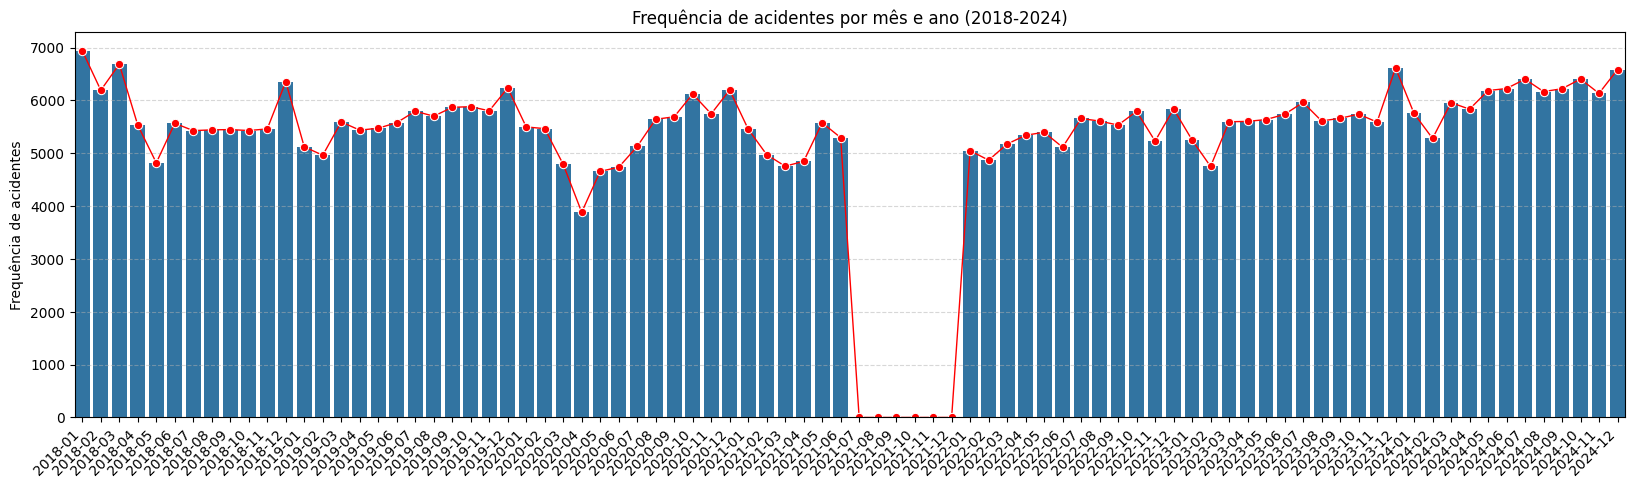

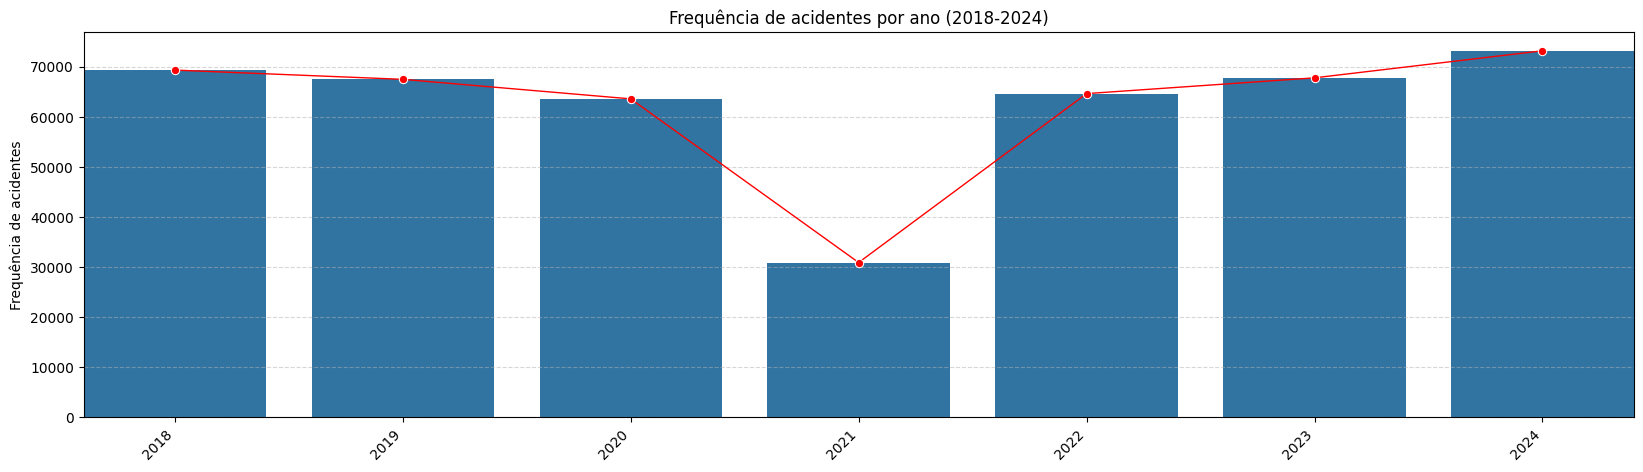

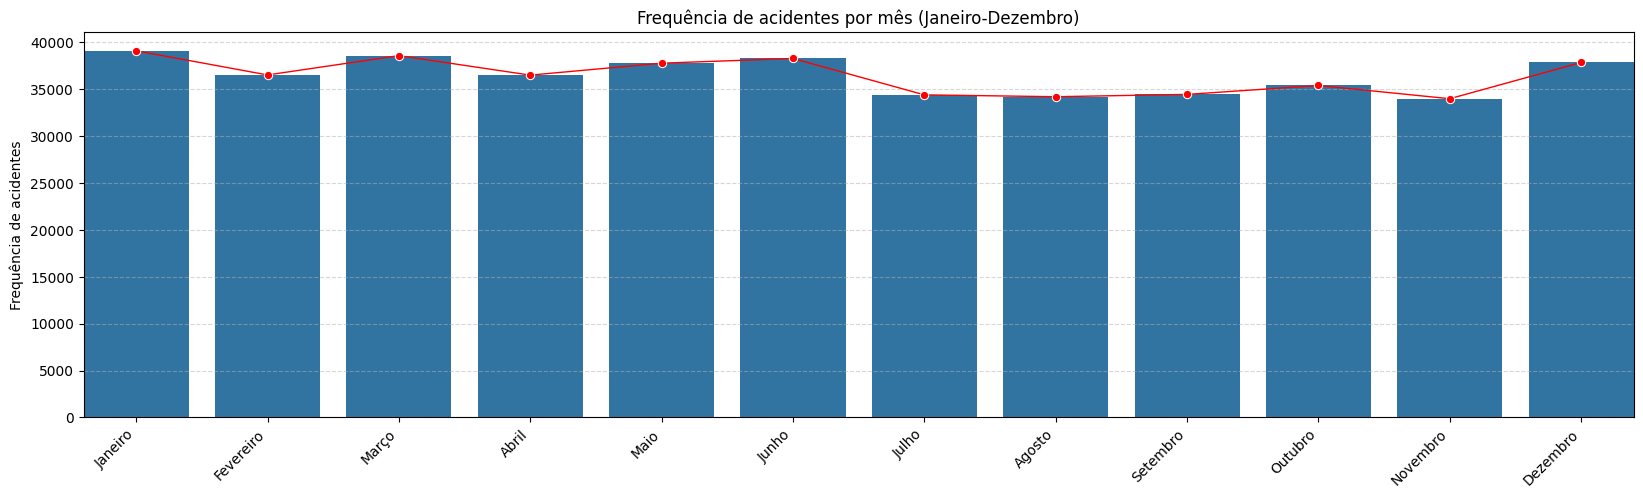

In [40]:
df_month_year = group_by_month_year()
draw(
    df=df_month_year,
    title="Frequência de acidentes por mês e ano (2018-2024)"
)
df_year = group_by_year()
draw(
    df=df_year,
    title="Frequência de acidentes por ano (2018-2024)"
)
df_month = group_by_month()
draw(
    df=df_month,
    title="Frequência de acidentes por mês (Janeiro-Dezembro)"
)

#### Analisando os dados do ano de 2021, foi possível perceber que os meses de julho a dezembro não foram populados. Para não influenciar negativamente nas análises, preencherei esses dados considerando a média ou mediana dos demais anos

In [ ]:
end_of_month = dict({7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31})


def fill_occurrences_dict(df, day, month, year):
    occurrences_dict = {}
    current_date = f'{year}-{month:02d}-{day:02d}'
    count = df_accidents[df == current_date].shape[0]
    occurrences_dict[current_date] = count
    return occurrences_dict


def create_lines_by_mean(day, month, mean):
    value = [pd.to_datetime(f'2021-{month:02d}-{day:02d}')] * mean
    return pd.DataFrame({
        'data_inversa': value, 'mes_ano': value,
    })


def fill_na(df):
    for col in df_accidents.columns:
        if col not in ('data_inversa', 'mes_ano'):
            df[col] = np.nan
    return df


for month in end_of_month:
    for day in range(1, end_of_month[month] + 1):
        for year in [2018, 2019, 2020, 2022, 2023, 2024]:
            occurrences = fill_occurrences_dict(
                df_accidents["data_inversa"], day, month, year)

        mean = int(np.mean(list(occurrences.values())))

        df = create_lines_by_mean(day, month, mean)
        df = fill_na(df)

        df_accidents = pd.concat(
            [df_accidents, df], ignore_index=True)

df_accidents["mes_ano"] = df_accidents["data_inversa"].dt.to_period("M")
df_accidents.to_csv(
    "analysis/datatran2018_2024__v2.csv", index=False)

#### Lendo a nova base de dados após o tratamento do ano de 2021

In [42]:
df_accidents = pd.read_csv(
    "analysis/datatran2018_2024_v2.csv",
    parse_dates=["data_inversa", "mes_ano"]
)
df_accidents.info()
df_accidents.reset_index(drop=True, inplace=True)

/var/folders/z1/3syxl8gd5ks431s8c9n9mrs00000gn/T/ipykernel_14769/2628785375.py:1: DtypeWarning: Columns (2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474548 entries, 0 to 474547
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      436643 non-null  float64       
 1   data_inversa            474548 non-null  datetime64[ns]
 2   tipo_data               436643 non-null  object        
 3   mes_ano                 474548 non-null  datetime64[ns]
 4   dia_semana              436643 non-null  object        
 5   horario                 436643 non-null  object        
 6   fase_dia                436643 non-null  object        
 7   condicao_metereologica  436643 non-null  object        
 8   uf                      436643 non-null  object        
 9   municipio               436643 non-null  object        
 10  br                      436643 non-null  object        
 11  km                      436643 non-null  object        
 12  uso_solo                436643

#### Análise da distribuição dos acidentes entre os anos de 2018 e 2024 (após o tratamento de 2021)

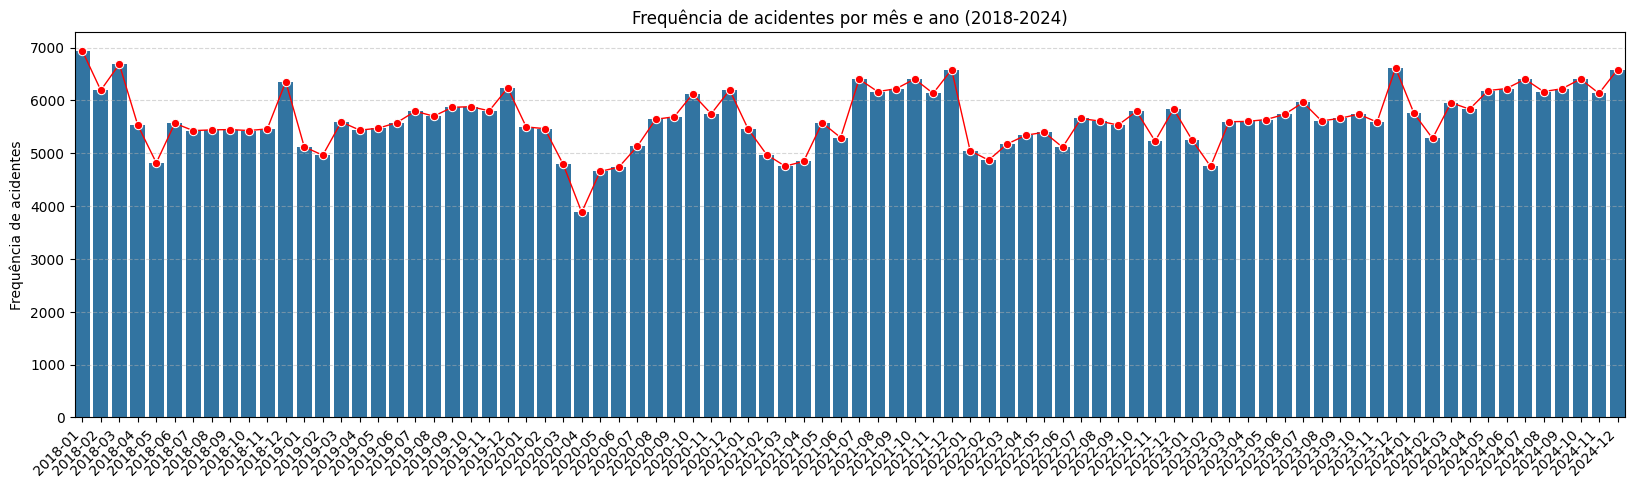

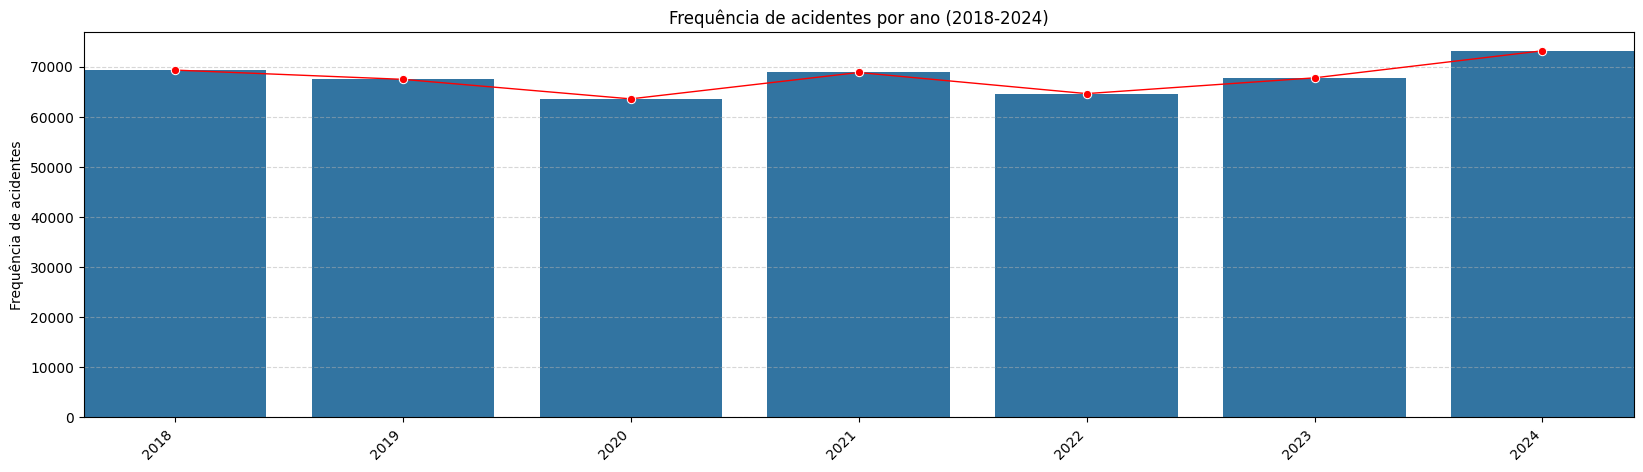

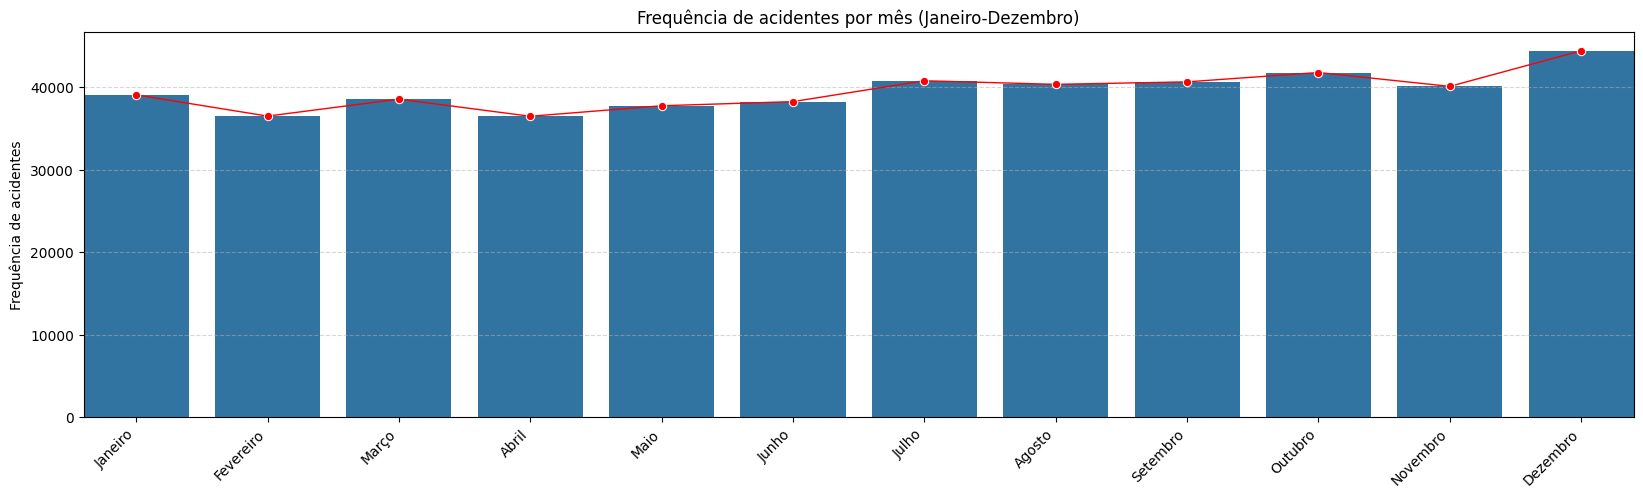

In [43]:
df_month_year = group_by_month_year()
draw(
    df=df_month_year,
    title="Frequência de acidentes por mês e ano (2018-2024)"
)
df_year = group_by_year()
draw(
    df=df_year,
    title="Frequência de acidentes por ano (2018-2024)"
)
df_month = group_by_month()
draw(
    df=df_month,
    title="Frequência de acidentes por mês (Janeiro-Dezembro)"
)